# Modeling and Simulation in Python

Bungee dunk example, taking into account the mass of the bungee cord

Copyright 2019 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [1]:
# If we're running on Colab, install modsimpy
# https://pypi.org/project/modsimpy/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install pint==0.9
    !pip install modsimpy
    !mkdir figs

In [2]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# import functions from the modsim.py module
from modsim import *

### Bungee jumping

In the previous case study, we simulated a bungee jump with a model that took into account gravity, air resistance, and the spring force of the bungee cord, but we ignored the weight of the cord.

It is tempting to say that the weight of the cord doesn't matter, because it falls along with the jumper.  But that intuition is incorrect, as explained by [Heck, Uylings, and Kędzierska](http://iopscience.iop.org/article/10.1088/0031-9120/45/1/007).  As the cord falls, it transfers energy to the jumper.   They derive a differential equation that relates the acceleration of the jumper to position and velocity:

$a = g + \frac{\mu v^2/2}{\mu(L+y) + 2L}$ 

where $a$ is the net acceleration of the number, $g$ is acceleration due to gravity, $v$ is the velocity of the jumper, $y$ is the position of the jumper relative to the starting point (usually negative), $L$ is the length of the cord, and $\mu$ is the mass ratio of the cord and jumper.

If you don't believe this model is correct, [this video might convince you](https://www.youtube.com/watch?v=X-QFAB0gEtE).

Following the example in Chapter 21, we'll model the jump with the following modeling assumptions:

1. Initially the bungee cord hangs from a crane with the attachment point 80 m above a cup of tea.

2. Until the cord is fully extended, it applies a force to the jumper as explained above.

3. After the cord is fully extended, it obeys [Hooke's Law](https://en.wikipedia.org/wiki/Hooke%27s_law); that is, it applies a force to the jumper proportional to the extension of the cord beyond its resting length.

4. The jumper is subject to drag force proportional to the square of their velocity, in the opposite of their direction of motion.

First I'll create a `Param` object to contain the quantities we'll need:

1. Let's assume that the jumper's mass is 75 kg and the cord's mass is also 75 kg, so `mu=1`.

2. The jumpers's frontal area is 1 square meter, and terminal velocity is 60 m/s.  I'll use these values to back out the coefficient of drag.

3. The length of the bungee cord is `L = 25 m`.

4. The spring constant of the cord is `k = 40 N / m` when the cord is stretched, and 0 when it's compressed.

I adopt the coordinate system and most of the variable names from [Heck, Uylings, and Kędzierska](http://iopscience.iop.org/article/10.1088/0031-9120/45/1/007).


In [3]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
N = UNITS.newton

In [4]:
params = Params(v_init = 0 * m / s,
                g = 9.8 * m/s**2,
                M = 75 * kg,                # mass of jumper
                m_cord = 75 * kg,           # mass of cord
                area = 1 * m**2,            # frontal area of jumper
                rho = 1.2 * kg/m**3,    # density of air
                v_term = 60 * m / s,        # terminal velocity of jumper
                L = 25 * m,                 # length of cord
                k = 40 * N / m)             # spring constant of cord

Now here's a version of `make_system` that takes a `Params` object as a parameter.

`make_system` uses the given value of `v_term` to compute the drag coefficient `C_d`.

It also computes `mu` and the initial `State` object.

In [5]:
def make_system(params):
    """Makes a System object for the given params.
    
    params: Params object
    
    returns: System object
    """
    M, m_cord = params.M, params.m_cord
    g, rho, area =  params.g, params.rho, params.area
    v_init, v_term = params.v_init, params.v_term
    
    # back out the coefficient of drag
    C_d = 2 * M * g / (rho * area * v_term**2)
    
    mu = m_cord / M
    init = State(y=0*m, v=v_init)
    t_end = 10 * s

    return System(params, C_d=C_d, mu=mu,
                  init=init, t_end=t_end)

Let's make a `System`

In [6]:
system = make_system(params)
system

,values
v_init,0.0 meter / second
g,9.8 meter / second ** 2
M,75 kilogram
m_cord,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
L,25 meter
k,40.0 newton / meter
C_d,0.3402777777777778 dimensionless


`drag_force` computes drag as a function of velocity:

In [7]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    
    returns: drag force in N
    """
    rho, C_d, area = system.rho, system.C_d, system.area

    f_drag = -np.sign(v) * rho * v**2 * C_d * area / 2
    return f_drag

Here's drag force at 20 m/s.

In [8]:
drag_force(20 * m/s, system)

-81.66666666666667 <Unit('kilogram * meter / second ** 2')>

The following function computes the acceleration of the jumper due to tension in the cord.

$a_{cord} = \frac{\mu v^2/2}{\mu(L+y) + 2L}$ 

In [9]:
def cord_acc(y, v, system):
    """Computes the force of the bungee cord on the jumper:
    
    y: height of the jumper
    v: velocity of the jumpter
    
    returns: acceleration in m/s
    """
    L, mu = system.L, system.mu
    
    a_cord = -v**2 / 2 / (2*L/mu + (L+y))
    return a_cord

Here's acceleration due to tension in the cord if we're going 20 m/s after falling 20 m.

In [10]:
y = -20 * m
v = -20 * m/s
cord_acc(y, v, system)

-3.6363636363636362 <Unit('meter / second ** 2')>

Now here's the slope function:

In [11]:
def slope_func1(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    M, g = system.M, system.g
    
    a_drag = drag_force(v, system) / M
    a_cord = cord_acc(y, v, system)
    dvdt = -g + a_cord + a_drag
    
    return v, dvdt

As always, let's test the slope function with the initial params.

In [12]:
slope_func1(system.init, 0, system)

(0.0 <Unit('meter / second')>, -9.8 <Unit('meter / second ** 2')>)

We'll need an event function to stop the simulation when we get to the end of the cord.

In [13]:
def event_func(state, t, system):
    """Run until y=-L.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: difference between y and -L
    """
    y, v = state   
    return y + system.L

We can test it with the initial conditions.

In [14]:
event_func(system.init, 0, system)

25 <Unit('meter')>

And then run the simulation.

In [15]:
results, details = run_ode_solver(system, slope_func1, events=event_func)
details.message

'A termination event occurred.'

Here's how long it takes to drop 25 meters.

In [16]:
t_final = get_last_label(results)
t_final

2.2118255911654763

Here's the plot of position as a function of time.

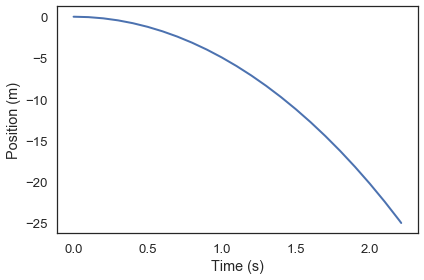

In [17]:
def plot_position(results, **options):
    plot(results.y, **options)
    decorate(xlabel='Time (s)',
             ylabel='Position (m)')
    
plot_position(results)

We can use `min` to find the lowest point:

In [18]:
min(results.y)

-25.0 <Unit('meter')>

Here's velocity as a function of time:

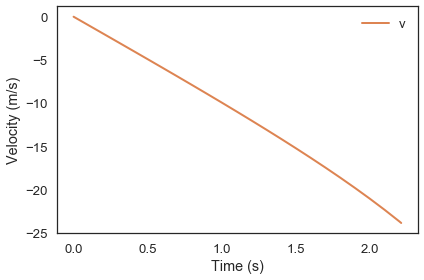

In [19]:
def plot_velocity(results):
    plot(results.v, color='C1', label='v')
        
    decorate(xlabel='Time (s)',
             ylabel='Velocity (m/s)')
    
plot_velocity(results)

Velocity when we reach the end of the cord.

In [20]:
min(results.v)

-23.876881009672466 <Unit('meter / second')>

Although we compute acceleration inside the slope function, we don't get acceleration as a result from `run_ode_solver`.

We can approximate it by computing the numerical derivative of `v`:

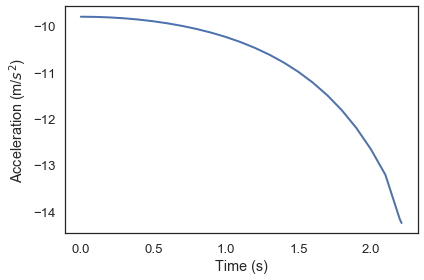

In [21]:
a = gradient(results.v)
plot(a)
decorate(xlabel='Time (s)',
         ylabel='Acceleration (m/$s^2$)')

The maximum downward acceleration, as a factor of `g`

In [22]:
max_acceleration = max(abs(a)) * m/s**2 / params.g

Using Equation (1) from [Heck, Uylings, and Kędzierska](http://iopscience.iop.org/article/10.1088/0031-9120/45/1/007), we can compute the peak acceleration due to interaction with the cord, neglecting drag.

In [23]:
def max_acceleration(system):
    mu = system.mu
    return 1 + mu * (4+mu) / 8

max_acceleration(system)

1.625 <Unit('dimensionless')>

If you set `C_d=0`, the simulated acceleration approaches the theoretical result, although you might have to reduce `max_step` to get a good numerical estimate.

### Sweeping cord weight

Now let's see how velocity at the crossover point depends on the weight of the cord.

In [24]:
def sweep_m_cord(m_cord_array, params):
    sweep = SweepSeries()

    for m_cord in m_cord_array:
        system = make_system(Params(params, m_cord=m_cord))
        results, details = run_ode_solver(system, slope_func1, events=event_func)
        min_velocity = min(results.v) * m/s
        sweep[m_cord.magnitude] = min_velocity
        
    return sweep

In [25]:
m_cord_array = linspace(1, 201, 21) * kg
sweep = sweep_m_cord(m_cord_array, params)

Here's what it looks like.  As expected, a heavier cord gets the jumper going faster.

There's a hitch near 25 kg that seems to be due to numerical error.

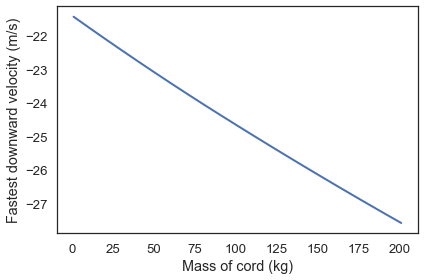

In [26]:
plot(sweep)

decorate(xlabel='Mass of cord (kg)',
         ylabel='Fastest downward velocity (m/s)')

### Phase 2

Once the jumper falls past the length of the cord, acceleration due to energy transfer from the cord stops abruptly.  As the cord stretches, it starts to exert a spring force.  So let's simulate this second phase.

`spring_force` computes the force of the cord on the jumper:

In [27]:
def spring_force(y, system):
    """Computes the force of the bungee cord on the jumper:
    
    y: height of the jumper
    
    Uses these variables from system:
    y_attach: height of the attachment point
    L: resting length of the cord
    k: spring constant of the cord
    
    returns: force in N
    """
    L, k = system.L, system.k
    
    distance_fallen = -y
    extension = distance_fallen - L
    f_spring = k * extension
    return f_spring

The spring force is 0 until the cord is fully extended.  When it is extended 1 m, the spring force is 40 N. 

In [28]:
spring_force(-25*m, system)

0.0 <Unit('newton')>

In [29]:
spring_force(-26*m, system)

40.0 <Unit('newton')>

The slope function for Phase 2 includes the spring force, and drops the acceleration due to the cord.

In [30]:
def slope_func2(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing g, rho,
            C_d, area, and mass
    
    returns: derivatives of y and v
    """
    y, v = state
    M, g = system.M, system.g
    
    a_drag = drag_force(v, system) / M
    a_spring = spring_force(y, system) / M
    dvdt = -g + a_drag + a_spring
    
    return v, dvdt

I'll run Phase 1 again so we can get the final state.

In [31]:
system1 = make_system(params)
system1

,values
v_init,0.0 meter / second
g,9.8 meter / second ** 2
M,75 kilogram
m_cord,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
L,25 meter
k,40.0 newton / meter
C_d,0.3402777777777778 dimensionless


In [32]:
event_func.direction=-1
results1, details1 = run_ode_solver(system1, slope_func1, events=event_func)
details1.message

'A termination event occurred.'

Now I need the final time, position, and velocity from Phase 1.

In [33]:
t_final = get_last_label(results1)
t_final

2.2118255911654763

In [34]:
init2 = results1.row[t_final]
init2

,values
y,-25.0 meter
v,-23.876881009672466 meter / second


And that gives me the starting conditions for Phase 2.

In [35]:
system2 = System(system1, t_0=t_final, init=init2)
system2

,values
v_init,0.0 meter / second
g,9.8 meter / second ** 2
M,75 kilogram
m_cord,75 kilogram
area,1 meter ** 2
rho,1.2 kilogram / meter ** 3
v_term,60.0 meter / second
L,25 meter
k,40.0 newton / meter
C_d,0.3402777777777778 dimensionless


Here's how we run Phase 2, setting the direction of the event function so it doesn't stop the simulation immediately. 

In [36]:
event_func.direction=+1
results2, details2 = run_ode_solver(system2, slope_func2, events=event_func)
details2.message

'A termination event occurred.'

In [37]:
t_final = get_last_label(results2)
t_final

8.09952482949752

We can plot the results on the same axes.

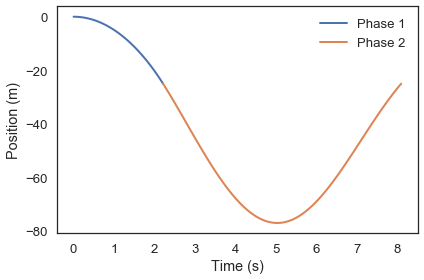

In [38]:
plot_position(results1, label='Phase 1')
plot_position(results2, label='Phase 2')

And get the lowest position from Phase 2.

In [39]:
min(results2.y)

-77.04609533183535 <Unit('meter')>

To see how big the effect of the cord is, I'll collect the previous code in a function.

In [40]:
def simulate_system2(params):
    
    system1 = make_system(params)
    event_func.direction=-1
    results1, details1 = run_ode_solver(system1, slope_func1, events=event_func)

    t_final = get_last_label(results1)
    init2 = results1.row[t_final]
    
    system2 = System(system1, t_0=t_final, init=init2)
    results2, details2 = run_ode_solver(system2, slope_func2, events=event_func)
    t_final = get_last_label(results2)
    return TimeFrame(pd.concat([results1, results2]))

Now we can run both phases and get the results in a single `TimeFrame`.

In [41]:
results = simulate_system2(params);

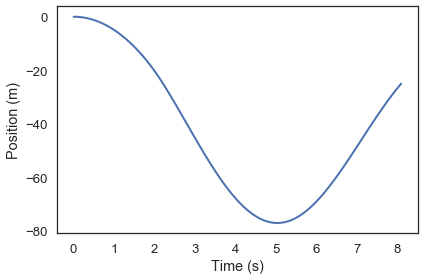

In [42]:
plot_position(results)

In [43]:
params_no_cord = Params(params, m_cord=1*kg)
results_no_cord = simulate_system2(params_no_cord);

Saving figure to file figs/jump.png


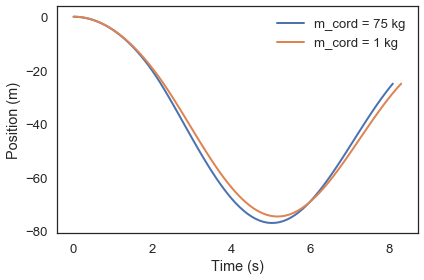

In [44]:
plot_position(results, label='m_cord = 75 kg')
plot_position(results_no_cord, label='m_cord = 1 kg')

savefig('figs/jump.png')

In [45]:
min(results_no_cord.y)

-74.62920556283255 <Unit('meter')>

In [46]:
diff = min(results.y) - min(results_no_cord.y)
diff

-2.4168897690027933 <Unit('meter')>

The difference is more than 2 meters, which could certainly be the difference between a successful bungee dunk and a bad day.